Cancer - Gene Co-Expression Network Construction
====

We have a theory to explain why cancer happens. The theory is that cancer happens when the cell system's entroy increases due to external forces and the cell moves uphill from the minimum free energy. As the cell system is robust, it tries to maintain itself and control the energy. But it is not always successful, the cell may enter a local minimum of free energy where it is now stabilized. These local minimums may be the points that cell becomes cancerous. We want to see if our hypothesis is correct.

To this end, we use Prostate cancer data derived from NCBI Gene Omnibus GDS2545 dataset. In this iPython notebook, we generate gene co-expression networks for the 4 cell phenotypes: Normal, Adjacent, Tumor, Metastasis. We then use the constructed networks in another notebook to explore the hypothesis.

---

For each phenotype, we want to use Spearman correlation coefficient to construct a gene co-expression network (See: http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0087075).

Below, pre-computed spearman matrices are loaded if available. Otherwise,raw expression data is loaded and the spearman matrix is computed for each phenotype.

In [1]:
import numpy as np
from scipy.stats import spearmanr

def read_raw_data(csv,metacols=None):
    """
    Reads expression data into a ndarray of expression data and tuple of gene identifiers.
    
    Parameters
    ----------
    csv : str
        Comma-separated csv file to read from. The first two columns are gene identifiers
        and prob_ids respectively. Next columns are expression data of each gene (rows)
        from different samples.
    metacols : int or None
        If csv contains meta data columns as defined in csv parameter, use this integer to
        separate them from expression data.
    
    Returns
    -------
    expression_data : ndarray or False
        The expression data. False when IO error happens.
    meta_data : ndarray
        The meta data matrix according to metacols provided.
    """
    try:
        raw_exp = np.genfromtxt(csv,delimiter=',',names=True,dtype=None)
        data_cols = list(raw_exp.dtype.names[metacols:])
        meta_cols = list(raw_exp.dtype.names[0:metacols])
        return raw_exp[data_cols].view(np.float64).reshape(raw_exp.shape[0],len(data_cols)),raw_exp[meta_cols]
    except IOError:
        return False,None

def read_or_calc_corr_data(dataset):
    """
    Reads correlation data from files or calculate them by first loading raw expression data. In
    this case, it also saves files to disk for later use.
    
    Parameters
    ----------
    dataset : str
        The string that is used to produce filenames. "%s-rs" is spearman correlation file,
        "%s-rs-p" is the pvalue of the correlation matrix and "%s.csv" is the raw expression
        data file.
        
    Returns
    -------
    rs : ndarray
        Correlation matrix
    pvalue : ndarray
        Correlation p-value matrix.
    """
    rs_filename = "%s-rs" % dataset
    pvalue_filename = "%s-rs-p" % dataset
    dataset_filename = "%s.csv" % dataset

    try:
        rs = np.fromfile(rs_filename)
        pvalue = np.fromfile(pvalue_filename)
        size = np.sqrt(rs.shape[0])
        rs = rs.reshape((size,size))
        pvalue = pvalue.reshape((size,size))
    except IOError:
        print "Need to calculate spearman correlation matrix. This takes a few minutes..."
        exp,meta = read_raw_data(dataset_filename)
        rs,pvalue = spearmanr(exp,axis=1)
        rs.tofile(rs_filename)
        pvalue.tofile(pvalue_filename)
    
    return rs,pvalue

normal_rs,normal_pvalue = read_or_calc_corr_data("normal")
tumor_rs,tumor_pvalue = read_or_calc_corr_data("tumor")

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:60: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:61: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


We need to set a cutoff to choose approperiate correlations and discard all others. We monitor the size of largest component of the graph and play with the cutoffs to reach a stable point.

In [2]:
import networkx as nx

def network(rs,pvalue,p=0.2,corr=0.7):
    """
    Builds a network from Spearman correlation coefficient matrix.
    
    Parameters
    ----------
    rs : ndarray
        Spearman correlation coefficient matrix
    pvalue : ndarray
        Spearman correlation coefficient respective p-values
    p : float
        Threshold for maximum possible p-value to choose from
    corr : float
        Threshold for minimum possible correlation to form a network
    
    Returns
    -------
    G : Graph
        A simple undirected graph.
    Adj: ndarray
        Adjacancy matrix of the graph G. Adj[i][j] shows correlation between nodes i and j.
    """
    zeros = np.zeros(rs.shape)
    rs_sig = np.where(pvalue < p,rs,zeros)
    rs_adj = np.where(np.absolute(rs_sig) > corr,rs_sig,zeros)
    np.fill_diagonal(rs_adj,0)
    G = nx.from_numpy_matrix(rs_adj)
    return G,rs_adj

In [ ]:
import itertools

pvalue_cuts = [0.05,0.1,0.15,0.2]
corr_cuts = [0.6,0.7,0.8,0.9]
for (p,c) in itertools.product(pvalue_cuts,corr_cuts):
    tumor_graph,tumor_adj = network(tumor_rs,tumor_pvalue,p=p,corr=c)
    tumor_gc = max(nx.connected_component_subgraphs(tumor_graph), key=len)
    print (p,c)
    print(tumor_gc.size())

In [3]:
normal_graph,normal_adj = network(normal_rs,normal_pvalue,p=0.2,corr=0.85)
normal_gc = max(nx.connected_component_subgraphs(normal_graph), key=len)

tumor_graph,tumor_adj = network(tumor_rs,tumor_pvalue,p=0.2,corr=0.6)
tumor_gc = max(nx.connected_component_subgraphs(tumor_graph), key=len)

In [6]:
nx.write_weighted_edgelist(normal_graph,"normal-graph.edges")
nx.write_weighted_edgelist(tumor_graph,"tumor-graph.edges")
nx.write_gml(normal_graph,"normal-graph.gml")
nx.write_gml(tumor_graph,"tumor-graph.gml")

Name: 
Type: Graph
Number of nodes: 4936
Number of edges: 38143
Average degree:  15.4550
Name: 
Type: Graph
Number of nodes: 3340
Number of edges: 35848
Average degree:  21.4659


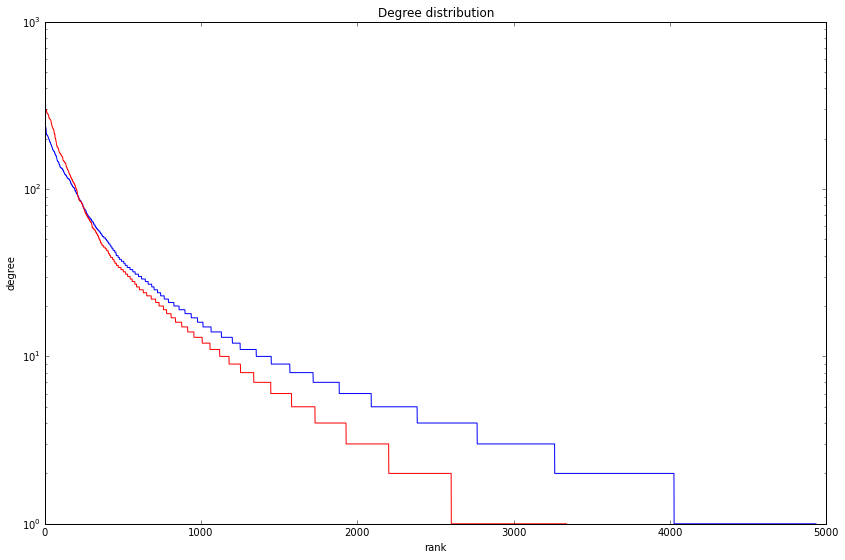

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(14, 9)

normal_degree_seq=sorted(nx.degree(normal_gc).values(),reverse=True) 
tumor_degree_seq=sorted(nx.degree(tumor_gc).values(),reverse=True)
plt.semilogy(normal_degree_seq,color='blue')
plt.title("Degree distribution")
plt.ylabel("degree")
plt.xlabel("rank")
plt.semilogy(tumor_degree_seq,color='red')

print nx.info(normal_gc)
print nx.info(tumor_gc)

In [9]:
pos=nx.spring_layout(normal_graph,weight=None)

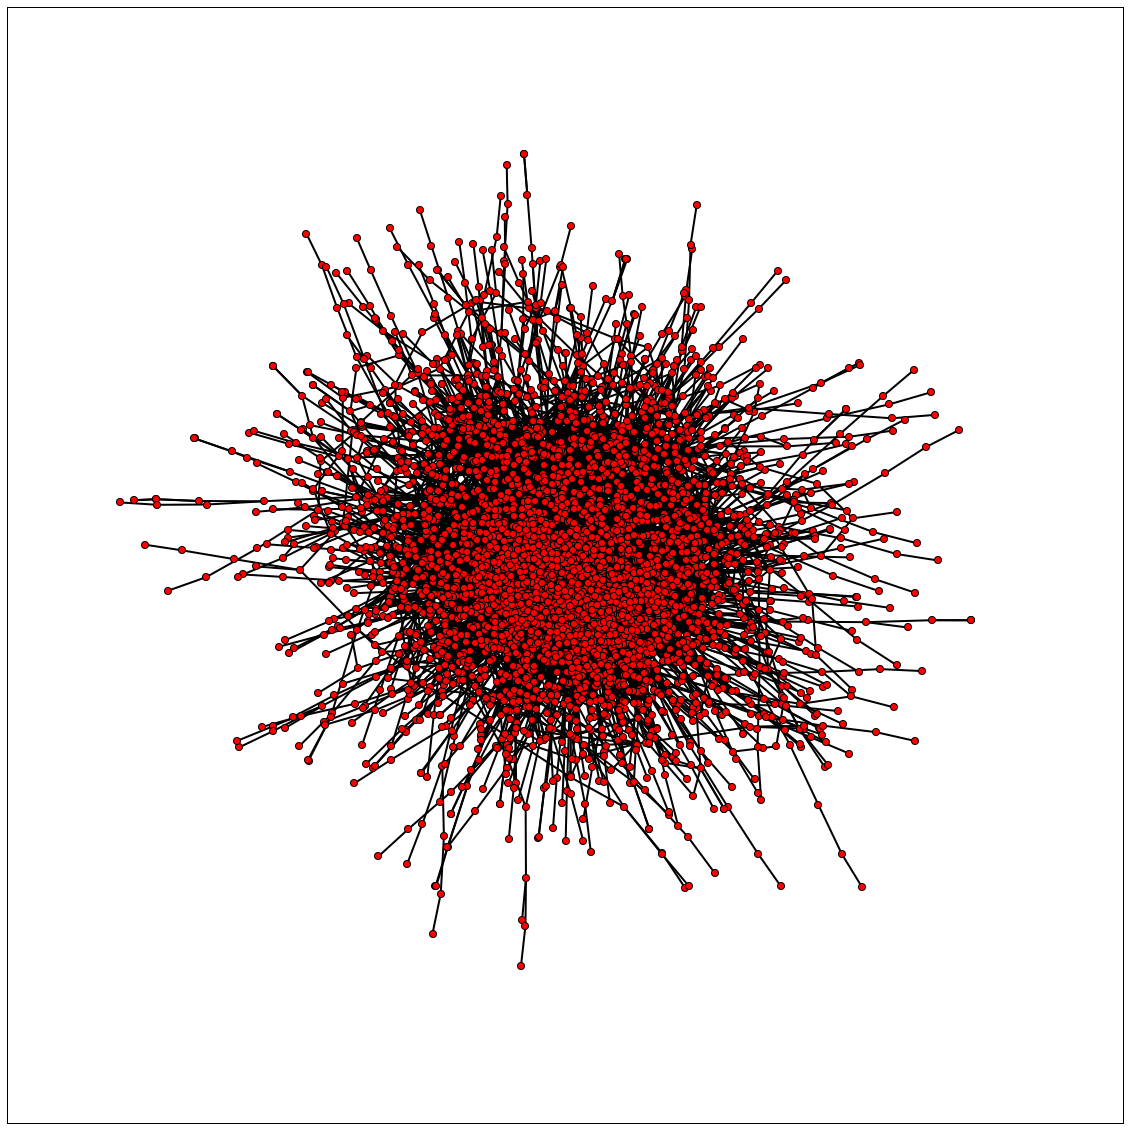

In [27]:
fig = plt.figure()
fig.set_size_inches(20,20)
fig.set_dpi(300)
nx.draw_networkx(normal_gc,pos=pos,with_labels=False,node_size=50,label="Normal Cell",width=2)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)


## References

1. http://www.sciencedirect.com/science/article/pii/S0378437107005675
* http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0087075